In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import spacy
from sklearn.metrics import confusion_matrix
import transformers
import torch
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [11]:
utterance_df= pd.read_csv('utterance_id.csv')
utterance_df

,Unnamed: 0,question,tags
0,0,List email from Richa?,Email
1,1,What did robert write to me regarding overview...,Email
2,2,When was the Diwali Celeberation?,Email
3,3,Show me all emails focused on covid19.,Email
4,4,Show me the important mails for today,Email
...,...,...,...
4592,4592,Heuristic,Keyword
4593,4593,Kaiser Permanente,Keyword
4594,4594,bharat kumar malviya,Keyword
4595,4595,Rental agreement,Keyword


In [12]:
utterance_df['tags'].value_counts()

tags
Contract    1590
Email       1162
Calendar     786
Contact      450
Document     398
Employee     126
Keyword       85
Name: count, dtype: int64

# Class Imbalance

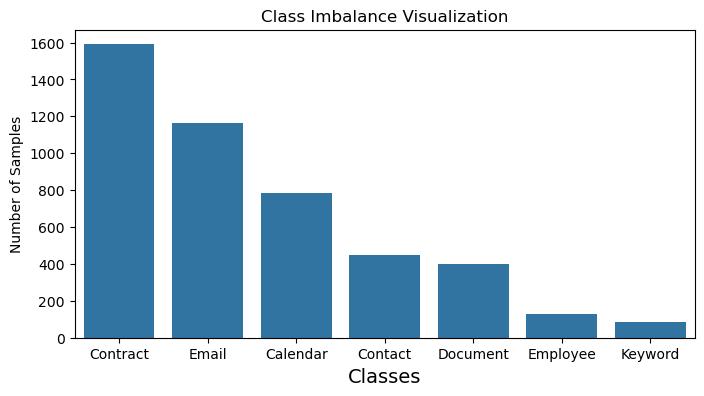

In [13]:
class_counts = utterance_df['tags'].value_counts()

#bar chart to check and visualize the class imbalance
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Class Imbalance Visualization')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Samples')
plt.show()


In [14]:
# Data Cleaning
nlp = spacy.load("en_core_web_sm")

def clean_text(text):

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)# removing special characters
    text = re.sub(r'\s+', ' ', text).strip()# deleting white spaces

    #doc = nlp(text)
    # Lemmatization and stopwords removal
    #cleaned_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    #cleaned_text = " ".join(cleaned_tokens)

    return text


# Apply cleaning
utterance_df['question'] = utterance_df['question'].apply(clean_text)

In [15]:
le = LabelEncoder()

utterance_df['label_encoded'] = le.fit_transform(utterance_df['tags'])

X_train, X_test, y_train, y_test = train_test_split(utterance_df['question'], utterance_df['label_encoded'], test_size=0.2, random_state=42, stratify=utterance_df['label_encoded'])

In [17]:
# Weights to handle class imbalance
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Logistic Regression Approach

In [18]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

class_weights_dict = {i: w for i, w in enumerate(class_weights)}

#Logistic Regression
clf = LogisticRegression(class_weight=class_weights_dict)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

    Calendar       0.95      0.96      0.95       157
     Contact       0.82      0.93      0.87        90
    Contract       0.98      0.96      0.97       318
    Document       0.79      0.86      0.83        80
       Email       0.98      0.94      0.96       233
    Employee       1.00      0.92      0.96        25
     Keyword       0.88      0.82      0.85        17

    accuracy                           0.94       920
   macro avg       0.91      0.91      0.91       920
weighted avg       0.94      0.94      0.94       920



<Axes: >

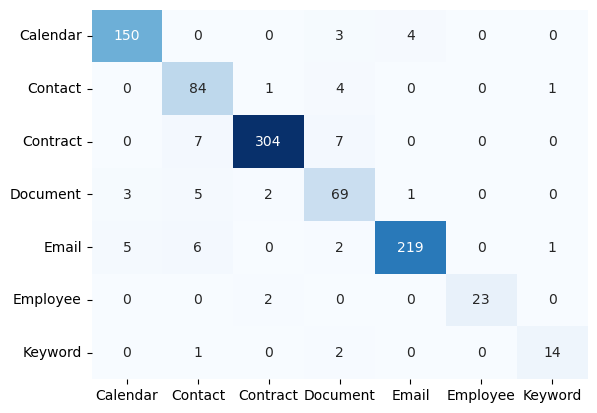

In [19]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)


In [20]:
le.classes_

array(['Calendar', 'Contact', 'Contract', 'Document', 'Email', 'Employee',
       'Keyword'], dtype=object)

# Embeddings Approach - BERT

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #tokenizer
model_bert = BertModel.from_pretrained('bert-base-uncased') # bert model


In [ ]:
#Preparing the dataset in the pytorch format.
class UtteranceDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), label

train_dataset = UtteranceDataset(X_train, y_train, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
# BERT classifier Model Architecture
class UtteranceClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size, output_size):
        super(UtteranceClassifier, self).__init__()
        self.bert = bert_model
        self.fc1 = nn.Linear(hidden_size,384)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(384, output_size)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output[1]
        output = self.relu(self.fc1(pooled_output))
        output = self.fc2(output)
        return output

utterance_model = UtteranceClassifier(bert_model=model_bert, hidden_size=768, output_size=7)
optimizer = optim.Adam(utterance_model.parameters(),lr = 1e-5)




In [ ]:
!nvidia-smi

Sat Apr 12 10:50:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Training Loop
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#moving the model to gpu device
utterance_model = utterance_model.to(device)

# Convert class_weights to Float before moving to GPU
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(10):
    for input_ids, attention_mask, labels in train_loader:
        # inputs and labels to the device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        #forward pass
        labels = labels.to(device)
        outputs = utterance_model(input_ids, attention_mask)

        loss = criterion(outputs, labels)# calculate loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # calculating gradients

    # Print loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.8700699806213379
Epoch 2, Loss: 0.4542050063610077
Epoch 3, Loss: 0.030509691685438156
Epoch 4, Loss: 0.020264629274606705
Epoch 5, Loss: 0.0160250011831522
Epoch 6, Loss: 0.009691739454865456
Epoch 7, Loss: 0.009114018641412258
Epoch 8, Loss: 0.006456444039940834
Epoch 9, Loss: 0.004240475594997406
Epoch 10, Loss: 0.0052667343989014626


In [ ]:
model_save_path = 'finetuned_bert_model_checkpoint.pt'

torch.save(utterance_model.state_dict(),model_save_path)

In [ ]:
#checkpoint = torch.load('finetuned_bert_model_checkpoint.pt')

# Load model
utterance_model.load_state_dict(torch.load('finetuned_bert_model_checkpoint.pt'))

<All keys matched successfully>

In [ ]:
test_dataset = UtteranceDataset(X_test, y_test, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

utterance_model.eval()

all_predictions = []
all_labels = []

# No gradient computation for inference
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        # Move inputs and labels to the same device as the model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = utterance_model(input_ids=input_ids, attention_mask=attention_mask)

        # Get the logits (raw predictions)
        logits = outputs
        predictions = torch.argmax(logits, dim=1)

        # Store predictions and labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print or evaluate the predictions
print(f"Predictions from BERT model: {all_predictions}")
print(f"True Labels: {all_labels}")

Predictions from BERT model: [4, 4, 2, 1, 1, 1, 4, 0, 0, 2, 4, 2, 2, 4, 2, 0, 3, 2, 4, 0, 3, 3, 2, 3, 0, 4, 2, 0, 2, 0, 4, 2, 0, 4, 4, 2, 2, 3, 0, 2, 1, 3, 0, 0, 4, 2, 0, 2, 4, 2, 2, 0, 0, 2, 1, 2, 4, 2, 0, 0, 2, 3, 0, 0, 4, 2, 2, 2, 1, 2, 1, 0, 4, 2, 2, 4, 4, 3, 2, 4, 4, 1, 0, 4, 4, 2, 2, 2, 2, 4, 2, 5, 2, 4, 2, 2, 2, 2, 0, 0, 2, 0, 3, 6, 2, 2, 2, 0, 4, 2, 2, 3, 4, 4, 6, 0, 2, 2, 1, 4, 4, 4, 2, 2, 4, 4, 6, 3, 0, 1, 1, 4, 2, 2, 2, 4, 4, 2, 3, 4, 3, 0, 3, 3, 3, 5, 2, 3, 1, 4, 4, 0, 3, 3, 4, 5, 3, 2, 0, 4, 0, 4, 0, 2, 2, 3, 4, 2, 2, 1, 3, 2, 5, 4, 2, 2, 2, 2, 3, 4, 2, 1, 3, 4, 3, 6, 2, 2, 0, 4, 4, 2, 0, 0, 4, 0, 4, 1, 2, 2, 2, 4, 4, 1, 4, 0, 2, 4, 2, 2, 2, 3, 4, 2, 5, 4, 0, 4, 3, 4, 4, 4, 2, 0, 2, 2, 2, 2, 4, 4, 4, 2, 0, 2, 4, 2, 5, 0, 1, 4, 3, 0, 0, 2, 2, 3, 6, 1, 1, 2, 5, 2, 4, 2, 4, 1, 2, 2, 0, 4, 0, 4, 2, 0, 4, 2, 0, 4, 2, 2, 1, 0, 4, 2, 1, 4, 1, 3, 2, 2, 4, 5, 2, 3, 4, 1, 0, 4, 2, 1, 4, 2, 0, 0, 0, 3, 1, 1, 2, 5, 4, 3, 2, 2, 5, 3, 3, 5, 2, 3, 4, 4, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2

<Axes: >

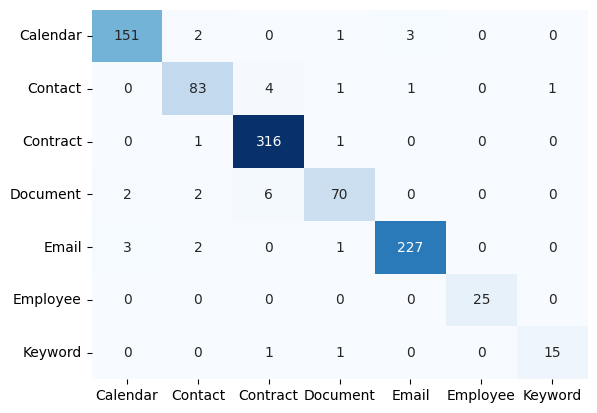

In [ ]:
cm_bert = confusion_matrix(all_labels,all_predictions)

sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)